In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_raw = pd.read_csv('data_ml.csv',index_col=0) 

# Chapter 1
## Notations and data

In [3]:
idx_date = (data_raw['date'] > '1999-12-31') & (data_raw['date'] < '2019-01-01')
data_ml = data_raw.loc[idx_date, :].sort_values(by=['stock_id', 'date']).copy()

data_ml.iloc[0:6, 0:6]  

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover
177279,1,2000-01-31,0.41,0.39,0.42,0.19
177280,1,2000-02-29,0.41,0.39,0.40,0.19
182908,1,2000-03-31,0.40,0.37,0.37,0.20
182909,1,2000-04-30,0.39,0.36,0.37,0.20
182910,1,2000-05-31,0.40,0.42,0.40,0.20
182911,1,2000-06-30,0.41,0.47,0.42,0.21


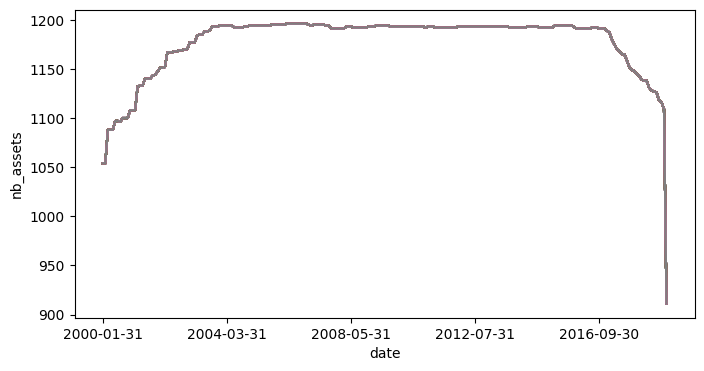

In [4]:
# counting the number of assets for each date
data_ml.groupby('date').count().plot(figsize=(8,4), legend=False) 
plt.ylabel('nb_assets');

In [5]:
features= list(data_ml.iloc[:,2:95].columns)
features_short =["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]

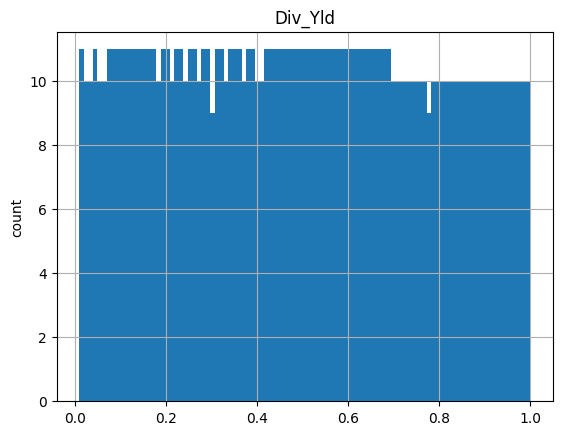

In [6]:
is_custom_date = data_ml['date']=='2000-02-29'
data_ml[is_custom_date].loc[:,['Div_Yld']].hist(bins=100) # using the hist 
plt.ylabel('count');

In [7]:
df_median = data_ml[['date','R1M_Usd','R12M_Usd']].groupby(['date']).median()
df_median.rename(columns = {"R1M_Usd": "R1M_Usd_median", "R12M_Usd": "R12M_Usd_median"}, inplace=True)
df = pd.merge(data_ml, df_median, how='left', on='date')
data_ml['R1M_Usd_C'] = np.where(df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0)
data_ml['R12M_Usd_C'] = np.where(df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0)
del df_median, df

In [8]:
separation_date = "2014-01-15"
idx_train = data_ml['date'] < separation_date
idx_test = data_ml['date'] >= separation_date

In [9]:
# A list of all stock_ids
stock_ids = data_ml['stock_id'].unique()
# compute the number of data points per stock
stock_days = data_ml[['date','stock_id']].groupby(['stock_id']).count().reset_index()
# Stocks with full data
stock_ids_short = stock_days.loc[stock_days['date'] == (stock_days['date'].max())] 
stock_ids_short = stock_ids_short['stock_id'].unique()
# compute returns in matrix format
is_stock_ids_short  =data_ml['stock_id'].isin(stock_ids_short)  
returns = data_ml[is_stock_ids_short].pivot(index='date', columns='stock_id', values='R1M_Usd') 

# Chapter 3 
## Factor investing and asset pricing anomalies

### 3.2.3 Simple portfolio sorts

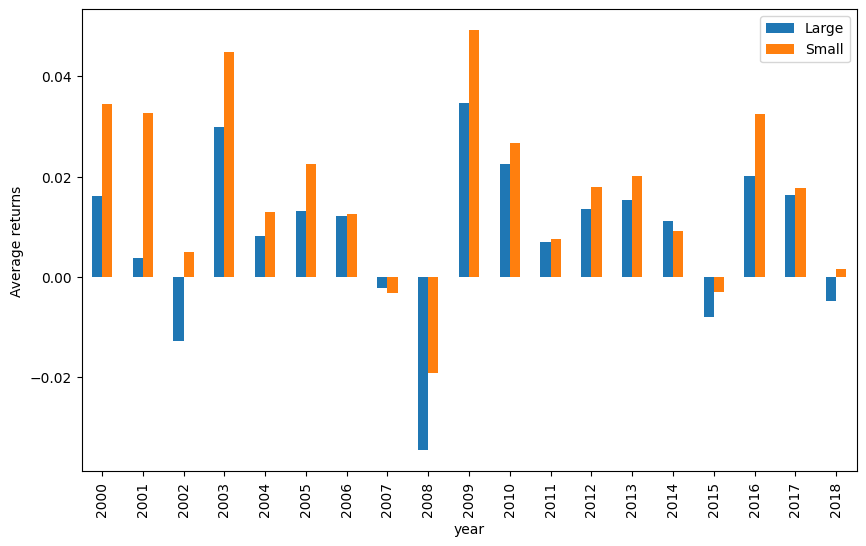

In [10]:
_median = data_ml[["date", "Mkt_Cap_12M_Usd"]].groupby(["date"]).median().reset_index()
_median.rename(columns = {'Mkt_Cap_12M_Usd': 'cap_median'}, inplace = True)
data_tmp = pd.merge(data_ml[["date", "R1M_Usd", "Mkt_Cap_12M_Usd"]], _median, 
                    how = "left", on = ["date"])
data_tmp["large"] = np.where(data_tmp["Mkt_Cap_12M_Usd"] > data_tmp["cap_median"], "Large", "Small")
data_tmp["year"] = pd.to_datetime(data_tmp['date']).dt.year
data_tmp = data_tmp.groupby(["year", "large"])["R1M_Usd"].mean().unstack()
data_tmp.loc[:, ["Large", "Small"]].plot.bar(figsize = (10, 6));
plt.ylabel('Average returns')
plt.xlabel('year')  
plt.legend(loc = "best");

### Import Data from Ken French's data library.

In [17]:
import urllib.request
import zipfile
import datetime

# download and unzip 
min_date = '1963-07-31'
max_date = '2020-03-01'
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip" 
urllib.request.urlretrieve(ff_url,"factors.zip")
file = zipfile.ZipFile("factors.zip")
file.extractall()
file.close()

# read_data
df_ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', 
                    header=2, index_col=0, sep=',', quotechar='"')
df_ff.rename(columns = {'Mkt-RF':'MKT_RF'}, inplace = True)
df_ff = df_ff.loc[:'202003', :] # hardcode
df_ff = df_ff.astype("float", copy=False)
df_ff[['MKT_RF','SMB','HML','RMW','CMA','RF']] /= 100.0
df_ff['date'] = pd.to_datetime(list(map(lambda x: datetime.datetime.strptime(x, "%Y%m"), 
                                        df_ff.index)))
df_ff['date'] += pd.offsets.MonthEnd(0) # month first -> month end
# process date for further use
df_ff['date'] = list(map(lambda x: str(x).split(" ")[0], df_ff['date']))
df_ff['year'] = pd.to_datetime(df_ff['date']).dt.year
df_ff.reset_index(drop=True, inplace=True)
idx_ff = (df_ff['date'] >= min_date) & (df_ff['date'] <= max_date)
FF_factors = df_ff.loc[idx_ff, :]

pd.concat([FF_factors.head(), FF_factors.tail()])

,MKT_RF,SMB,HML,RMW,CMA,RF,date,year
0,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,1963-07-31,1963
1,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025,1963-08-31,1963
2,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,1963-09-30,1963
3,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029,1963-10-31,1963
4,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,1963-11-30,1963
675,0.0206,0.0026,-0.0192,0.0044,-0.0096,0.0016,2019-10-31,2019
676,0.0387,0.0044,-0.0201,-0.0159,-0.0125,0.0012,2019-11-30,2019
677,0.0277,0.0097,0.0176,0.0000,0.0123,0.0014,2019-12-31,2019
678,-0.0011,-0.0437,-0.0622,-0.0118,-0.0232,0.0013,2020-01-31,2020
679,-0.0813,0.0003,-0.0379,-0.0147,-0.0251,0.0012,2020-02-29,2020


### Figure 3.2
### Average monthly return aggregated over each calendar year for five common factors.

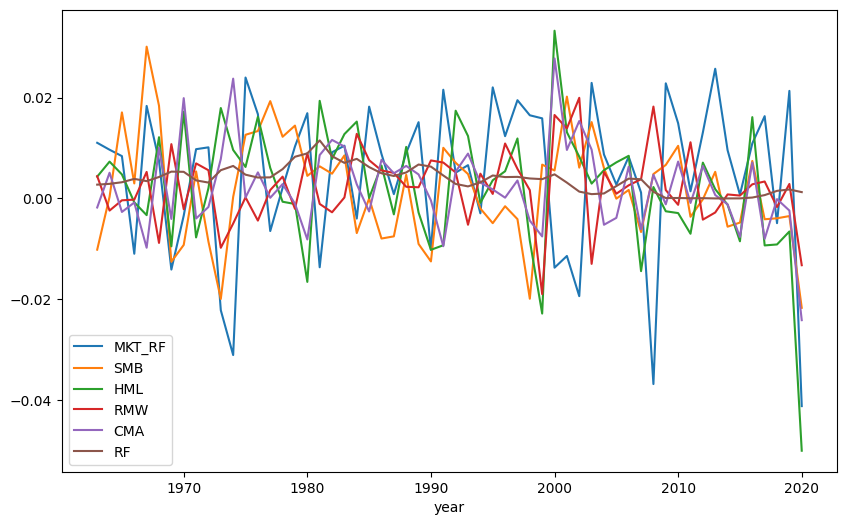

In [18]:
FF_factors.groupby(["year"])[['MKT_RF','SMB','HML','RMW','CMA','RF']].mean().plot(figsize= (10, 6))
plt.legend(loc = "best");